In [1]:
# Load modules, packages, and functions
! pip install pandas
! pip install pydicom
! pip install seaborn
! pip install memory_profiler
%load_ext memory_profiler

import glob, pylab, pandas as pd
import pydicom, numpy as np
from torch.utils.data import DataLoader, TensorDataset
from skimage.transform import resize
from skimage.exposure import equalize_hist

import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette(sns.dark_palette("purple"))

import torch
cuda = torch.cuda.is_available()

from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from functools import reduce

import torch.nn as nn
from torch.nn.functional import softplus
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from itertools import cycle
import operator
from torch.nn import Linear, GRU, Conv2d, Dropout, Dropout2d, MaxPool2d, BatchNorm1d, BatchNorm2d, ReLU, ELU, ConvTranspose2d, MaxUnpool2d, Softmax, Sigmoid, Softsign
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax, dropout, dropout2d, interpolate
import time

You are using pip version 9.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
def logging( i, print_every, no_samples, tic, elapsed_time):
    """
    Function for logging: timing and counting
    Inputs:
    - i:            Iteration i 
    - print_every:  Print logging in the interval of print_every
    - no_samples:   Number of samples
    - tic:          Start timer for last time
    - elapsed_time: Amount of time elapsed 
    """
    if not i % print_every:
        toc = time.clock()
        period_time = toc - tic;
        if i > 0:
            elapsed_time = (elapsed_time + period_time)
            mean_period_time = elapsed_time/ ((i)/print_every)
            minutes = round(mean_period_time*( (No_samples_train-i)//print_every)//60)
            seconds = round(mean_period_time*( (No_samples_train-i)/print_every)%60)
            print("Data loaded:", i,"/",No_samples_train,  "    Remaining time: ", minutes,":", seconds)
        tic = time.clock(); 
    else:
        tic = -1
        elapsed_time = -1
    return tic, elapsed_time


def uniform_stratified_sampler(labels, n=None):
    """
    Stratified sampler that distributes labels uniformly by
    sampling at most n data points per class
    """
    from functools import reduce
    # Only choose digits in n_labels
    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))

    # Ensure uniform distribution of labels
    np.random.shuffle(indices)
    indices = np.hstack([list(filter(lambda idx: labels[idx] == i, indices))[:n] for i in classes])

    indices = torch.from_numpy(indices)
    sampler = SubsetRandomSampler(indices)
    return sampler


def construct_DataLoader( Target, Image, batch_size, labels_per_class=None):
    """
    Contruct DataLoader with tensors
    Inputs:
    - Target:            Iteration i 
    - Image:  Print logging in the interval of print_every
    - batch_size
    """
    # Convert to Tensor
    Target = torch.Tensor(Target)
    Image = torch.Tensor(Image)
    Image = Image.unsqueeze(1)

    # Construct DataLoader
    loader = TensorDataset(Image, Target)
    if labels_per_class==None:
        dataLoader = DataLoader(loader, batch_size=batch_size, shuffle = True)
    else:    
        dataLoader = DataLoader(loader, batch_size=batch_size,
                     sampler=uniform_stratified_sampler(Target, labels_per_class))
    return dataLoader

In [3]:
######### Defining the data set #########

KAGGLE = False
 
# Display label format
if KAGGLE:
    df = pd.read_csv('../input/stage_2_detailed_class_info.csv')
    df.rename(columns={'class': 'Target'}, inplace=True)
    mapping = {'Normal': 0, 'Lung Opacity': 1, 'No Lung Opacity / Not Normal': 2}
    df = df.replace({'Target': mapping})
    df = df[ df['Target']!=2 ]
    df = df.reset_index(drop=True)
else:
    df = pd.read_csv('data/stage_1_train_labels.csv')

# Defining the size of the data set
classes = [0,1]          # ['Normal , 'Lung Opacity']  
batch_size       = 64
labels_per_class = 32    # Specify how many labelled examples we want per class
No_samples_train_labelled = labels_per_class*len(classes)
No_samples_train = 64
No_samples_test  = 64
IMG_SIZE         = 32
img_dimension = [IMG_SIZE,IMG_SIZE]


# Test connection to data set
No = 4
patientId = df['patientId'][No]
if KAGGLE:
    dcm_file = '../input/stage_2_train_images/%s.dcm' % patientId
else:
    dcm_file = 'data/stage_1_train_images/%s.dcm' % patientId
dcm_data = pydicom.read_file(dcm_file)
print(df.iloc[No])

# Get only unique entrances from the provided data (some patients occur multiple times)
unq, idx = np.unique(df['patientId'], return_index = True)

patientId    00436515-870c-4b36-a041-de91049b9ab4
x                                             264
y                                             152
width                                         213
height                                        379
Target                                          1
Name: 4, dtype: object


In [4]:
######### Load data into DataLoader's #########
# Load unlabelled training data
# Load labelled test data
# Load labelled training data

print_every = 10
Do_img_eq = True

######### Loading UNLABELED TRAINING data #########
Target = []; Image = []
tic = time.clock(); elapsed_time = 0

print("Loading training images: 0 /", No_samples_train)
for i in range(0,No_samples_train):
    Target.append(df.Target[idx[i]]) # Get label  
    patientId = df['patientId'][idx[i]] # Get patient id from the idx 
    if KAGGLE:
        dcm_file = '../input/stage_2_train_images/%s.dcm' % patientId # find the image-file corresponding to the patient id
    else:
        dcm_file = 'data/stage_1_train_images/%s.dcm' % patientId # find the image-file corresponding to the patient id
    dcm_data = pydicom.read_file(dcm_file) # Load the image 
    Image.append(resize(dcm_data.pixel_array, output_shape=img_dimension, mode='reflect'))#, anti_aliasing=True)) # resize image
    if Do_img_eq:
        Image[-1] = equalize_hist(Image[-1])
    
    # Logging: counting and time remaining
    val1, val2 = logging(i, print_every, No_samples_train, tic, elapsed_time)
    if not val1 == -1:
        tic = val1
        elapsed_time = val2    
    i = i + 1
    
print("Train data loaded:", i)
train_loader = construct_DataLoader( Target, Image, batch_size)
print(' ')


######### Loading TEST data #########
Target = []; Image = []
tic = time.clock(); elapsed_time = 0
for i in range(0,No_samples_test):
    Target.append(df.Target[idx[No_samples_train+i]]) # Get label  
    patientId = df['patientId'][idx[No_samples_train+i]] # Get patient id from the idx 
    if KAGGLE:
        dcm_file = '../input/stage_2_train_images/%s.dcm' % patientId # find the image-file corresponding to the patient id
    else:
        dcm_file = 'data/stage_1_train_images/%s.dcm' % patientId # find the image-file corresponding to the patient id
    dcm_data = pydicom.read_file(dcm_file) # Load the image 
    Image.append(resize(dcm_data.pixel_array, output_shape=img_dimension, mode='reflect'))#, anti_aliasing=True)) # resize image
    if Do_img_eq:
        Image[-1] = equalize_hist(Image[-1])
        
    # Logging: counting and time remaining
    val1, val2 = logging(i, print_every, No_samples_test, tic, elapsed_time)
    if not val1 == -1:
        tic = val1
        elapsed_time = val2
    i = i + 1
    
print("Test data loaded:", i)
test_loader = construct_DataLoader( Target, Image, batch_size)
print(' ')


######### Loading LABELED TRAINING data #########
Target = []; Image = []
tic = time.clock(); elapsed_time = 0
count_unlabelled = 0; count_labelled = 0
count_old = 0;
i = 0
while count_labelled<labels_per_class or count_unlabelled<labels_per_class:
    Target.append(df.Target[idx[No_samples_test+No_samples_train+i]]) # Get label  

    if Target[i]==1:
        count_labelled = count_labelled + 1
    else:
        count_unlabelled = count_unlabelled + 1
        
    patientId = df['patientId'][idx[No_samples_test+No_samples_train+i]] # Get patient id from the idx 
    if KAGGLE:
        dcm_file = '../input/stage_2_train_images/%s.dcm' % patientId # find the image-file corresponding to the patient id
    else:
        dcm_file = 'data/stage_1_train_images/%s.dcm' % patientId # find the image-file corresponding to the patient id
    dcm_data = pydicom.read_file(dcm_file) # Load the image 
    Image.append(resize(dcm_data.pixel_array, output_shape=img_dimension, mode='reflect'))#, anti_aliasing=True)) # resize image
    if Do_img_eq:
        Image[-1] = equalize_hist(Image[-1])

    # Logging: counting and time remaining
    count = min(count_labelled, count_unlabelled)
    if (count > count_old):
        count_old = min(count_labelled, count_unlabelled)
        val1, val2 = logging(2*count, print_every, No_samples_train_labelled, tic, elapsed_time)
        if not val1 == -1:
            tic = val1
            elapsed_time = val2  
    i = i + 1

print("Labelled data loaded:", i)
train_loader_labelled = construct_DataLoader( Target, Image, batch_size, labels_per_class)

del df, idx, unq

Loading training images: 0 / 64


/usr/local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Data loaded: 10 / 64     Remaining time:  0 : 1
Data loaded: 20 / 64     Remaining time:  0 : 1
Data loaded: 30 / 64     Remaining time:  0 : 0
Data loaded: 40 / 64     Remaining time:  0 : 0
Data loaded: 50 / 64     Remaining time:  0 : 0
Data loaded: 60 / 64     Remaining time:  0 : 0
Train data loaded: 64
 
Data loaded: 10 / 64     Remaining time:  0 : 1
Data loaded: 20 / 64     Remaining time:  0 : 0
Data loaded: 30 / 64     Remaining time:  0 : 1
Data loaded: 40 / 64     Remaining time:  0 : 0
Data loaded: 50 / 64     Remaining time:  0 : 0
Data loaded: 60 / 64     Remaining time:  0 : 0
Test data loaded: 64
 
Data loaded: 10 / 64     Remaining time:  0 : 1
Data loaded: 20 / 64     Remaining time:  0 : 1
Data loaded: 30 / 64     Remaining time:  0 : 1
Data loaded: 40 / 64     Remaining time:  0 : 0
Data loaded: 50 / 64     Remaining time:  0 : 0
Data loaded: 60 / 64     Remaining time:  0 : 0
Labelled data loaded: 87


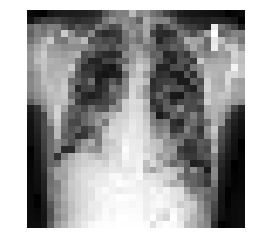

In [5]:
# Show an example image 
im = Image[5]
pylab.imshow(im, cmap=pylab.cm.gist_gray)
pylab.axis('off')

if cuda:
    torch.cuda.max_memory_cached(device=0)
    torch.cuda.memory_allocated(device = 0)

In [6]:
## Define size variables
print_shapes = False
height = IMG_SIZE
width = IMG_SIZE
channels = 1
num_features = height*width*channels

# Regulization
L2_reg = 1e-6
DROPOUT = True
do_p = 0.05 # do_p for conv 
do_p2 = 0.1 # do_p for linear   NB: Classifier dropout is set manuel to 0.3
batchnorm_eps = 1e-5
batchnorm_momentum = 0.2

# Conv Layers
conv_out_channels = [8, 32, 64]
conv_kernel = [5, 5, 3]
conv_padding = [0, 2, 1]
conv_stride = [1, 1, 1]

# MaxPool Layers
pool_kernel = 3
pool_padding = 0
pool_stride = 3

# Fully connected layers
lin_layer = [1000, 200]

# auxillary parameters
aux_layer = [200, 200]
aux_variables = 0
aux_in = 2 # layer no. where a is included in encoder
aux_decoder_layers = [200,200]

# classifier parameters
classifier_layer = [1000,200]
No_classes = len(classes)

# No. of layes
NUM_CONV = len(conv_out_channels)
NUM_LIN = len(lin_layer)
NUM_AUX = len(aux_layer)
NUM_CLASS = len(classifier_layer)
NUM_AUX_DECODER = len(aux_decoder_layers)

# Calculating the dimensions 
def compute_conv_dim(height, width, kernel_size, padding_size, stride_size):
    height_new = int((height - kernel_size + 2 * padding_size) / stride_size + 1)
    width_new =  int((width  - kernel_size + 2 * padding_size) / stride_size + 1)
    return [height_new, width_new]

def compute_final_dimension(height, width, last_num_channels, num_layers):
    # First conv layer
    CNN_height = height
    CNN_width = width
    for i in range(num_layers):
        # conv layer
        CNN_height, CNN_width = compute_conv_dim(CNN_height, CNN_width, conv_kernel[i], conv_padding[i], conv_stride[i])
        # maxpool layer
        CNN_height, CNN_width = compute_conv_dim(CNN_height, CNN_width, pool_kernel, pool_padding, pool_stride)
    final_dim = CNN_height * CNN_width * last_num_channels
    print(final_dim,CNN_height,CNN_width)
    return [final_dim, CNN_height, CNN_width]

def normalize(x):
    tmp = x-torch.min( torch.min(x,dim = 2, keepdim = True)[0] ,dim = 3, keepdim = True)[0]
    if torch.sum(torch.isnan(tmp))>0:
        print("nan of tmp",torch.sum(torch.isnan(tmp)))
    return tmp/(torch.max( torch.max(tmp,dim = 2, keepdim = True)[0] ,dim = 3, keepdim = True)[0] + 1e-8)  

def gaussian_sample(mu,log_var, num_samples, latent_features):    
    # Don't propagate gradients through randomness
    with torch.no_grad():
        batch_size = mu.size(0)
        epsilon = torch.randn(batch_size, num_samples, latent_features)
            
    if cuda:
        epsilon = epsilon.cuda()
        
    sigma = torch.exp(log_var/2)
        
    # We will need to unsqueeze to turn
    # (batch_size, latent_dim) -> (batch_size, 1, latent_dim)
    if len(mu.shape) == 2:
        z = mu.unsqueeze(1) + epsilon * sigma.unsqueeze(1)
    else:
        z = mu + epsilon * sigma
    return z

def output_recon(x):
    # Shape of x_mean: [batch_size, num_samples, channel, height, width]
    x_mean, x_log_var = torch.chunk(x, 2, dim=2) # the mean and log_var reconstructions from the decoder
    
    # The original digits are on the scale [0, 1] 
    x_hat = x_mean[:,1,].unsqueeze(1)
    #x_hat = normalize(x_mean[:,1,].unsqueeze(1))# to scale for showing an image
    #x_hat = normalize(x_mean)
    x_log_var = softplus(x_log_var)
    
    # Mean over samples
    #x_hat = torch.mean(x_hat, dim=1)
    x_log_var= torch.mean(x_log_var, dim=1)
    x_mean = torch.mean(x_mean,dim=1) # used for the loss
    
    # Resize x_hat from [batch_size, no_features] to [batch_size, channels, height, width]
    x_hat = x_hat.view( batch_size, 1, height, width)
    x_log_var = x_log_var.view( batch_size, 1, height, width)
    return x_hat, x_log_var, x_mean

######## Image has to be: (num, channels, height, width)!!!! #########
class CNN_VAE(nn.Module):
    def encoder(self,x):
        # Convolutional layers of encoder
        for i in range(0,len(self.Encoder_conv),3):
            x = self.Encoder_conv[i](x) # Convolutional layer
            self.layer_size.append(x.shape[-1])
            x = self.Encoder_conv[i+1](x) # Batchnorm layer
            x = relu(x)
            if DROPOUT:
                x = dropout2d(x, p=do_p)   
            x = self.Encoder_conv[i+2](x) # Maxpool Layer
        x = x.view(batch_size, -1) # Prepare x for linear layers
        
        # Fully connected layers of encoder
        for i in range(0,len(self.Encoder_FC),2): 
            x = self.Encoder_FC[i](x) # Linear layer
            x = self.Encoder_FC[i+1](x) # Batchnorm
            x = relu(x)
            if DROPOUT:
                x = dropout(x, p=do_p2)
        return x

    
    def decoder(self,z,y):
        x = torch.cat([z,y],dim=-1)
        # Fully connected layers of decoder
        for i in range(0,len(self.Decoder_FC),2):
            x = self.Decoder_FC[i](x)
            x = x.permute(0,2,1)
            x = self.Decoder_FC[i+1](x)
            x = x.permute(0,2,1)
            x = relu(x)
            x = dropout(x,p= do_p2)
        x = x.view(-1, self.Decoder_conv[0].in_channels, self.final_dim[1], self.final_dim[2])
        
        # Convolutional layers of decoder
        curr_layer = len(self.Decoder_conv)//2-1
        for i in range(0,len(self.Decoder_conv),2):
            x = interpolate(x,size = [self.layer_size[curr_layer],self.layer_size[curr_layer]],
                                      mode = 'bilinear', 
                                      align_corners = False)
            curr_layer -=1
            x = self.Decoder_conv[i](x) # Convolutional layers
            x = self.Decoder_conv[i+1](x) # BatchNorm
            x = relu(x)
            if DROPOUT:
                x = dropout2d(x, p=do_p)
        return x.view(batch_size,-1,channels*2,height,width)
            
    def encoder_aux(self,a):
        for i in range(0,len(self.Encoder_aux),2):
            a = self.Encoder_aux[i](a)
            a = self.Encoder_aux[i+1](a)
            a = relu(a)
            if DROPOUT:
                a = dropout(a, p=do_p2)
        q_a_mu, q_a_log_var = torch.chunk(a, 2, dim=-1) # divide to mu and sigma
        return q_a_mu, q_a_log_var
    
    def decoder_aux(self,xz,y):
        a = torch.cat([xz,y],dim=-1)
        for i in range(0,len(self.Decoder_aux),2):
            a = self.Decoder_aux[i](a)
            a = a.permute(0,2,1)
            a = self.Decoder_aux[i+1](a)
            a = a.permute(0,2,1)
            a = relu(a)
            if DROPOUT:
                a = dropout(a, p=do_p2)  
        return a
    
    def additional_layer(self,xa,y):
        z = torch.cat([xa,y],dim=-1)
        z = self.Additional_layer[0](z)
        z = z.permute(0,2,1)
        z = self.Additional_layer[1](z)
        z = z.permute(0,2,1)
        z = relu(z)
        if DROPOUT:
            z = dropout(z, p=do_p2) 
        return z
    
    def classifier(self,xa):
        for i in range(0,len(self.Classifier),2):
            xa = self.Classifier[i](xa)
            if i < len(self.Classifier)-1:
                if aux_variables > 0:
                    xa = xa.permute(0,2,1)
                    xa = self.Classifier[i+1](xa)
                    xa = xa.permute(0,2,1)
                else:
                    xa = self.Classifier[i+1](xa)
                xa = relu(xa)
                if DROPOUT:
                    xa = dropout(xa, p=0.3)
        return softmax(xa,dim=-1)
    
    def sample_y(self,batch_size,num_samples,no_classes,i):
        tmp = Variable(torch.zeros(no_classes))
        tmp[i] = 1
        if cuda:
            tmp = tmp.cuda()
        return tmp.repeat(batch_size,num_samples,1)
    
    def sample_from_latent(self,x):
        x_UL = []
        for j in range(No_classes):
            tmp = self.decoder(x.unsqueeze(1).repeat(1,num_samples,1), self.sample_y(batch_size,num_samples,No_classes,j))
            x_UL.append(tmp)
        x_hat, _, _ = output_recon(sum(x_UL))
        return x_hat
  
    
    def __init__(self, latent_features, num_samples):
        super(CNN_VAE, self).__init__()
        
        self.latent_features = latent_features
        self.num_samples = num_samples
        
        # Calculate final size of the CNN
        self.final_dim = compute_final_dimension(height,width,conv_out_channels[-1],NUM_CONV)
        
        ## Convolutional layers of the encoder
        input_channels = channels
        Encoder_conv = nn.ModuleList()
        for i in range(NUM_CONV):
            Encoder_conv.append(Conv2d( in_channels=input_channels,
                                            out_channels=conv_out_channels[i],
                                            kernel_size=conv_kernel[i],
                                            stride=conv_stride[i],
                                            padding=conv_padding[i]))
            Encoder_conv.append(BatchNorm2d(conv_out_channels[i], eps = batchnorm_eps, momentum = batchnorm_momentum))
            Encoder_conv.append(MaxPool2d(  kernel_size=pool_kernel, 
                                        stride=pool_stride,
                                        padding=pool_padding,
                                        return_indices = False))
            input_channels = conv_out_channels[i]
        self.add_module("Encoder_conv",Encoder_conv)
        
        # Fully connected layers of encoder
        Encoder_FC = nn.ModuleList()
        in_weights = self.final_dim[0]
        for i in range(NUM_LIN):
            Encoder_FC.append(Linear(in_features=in_weights, out_features=lin_layer[i]))
            Encoder_FC.append(BatchNorm1d(lin_layer[i], eps = batchnorm_eps, momentum = batchnorm_momentum))
            in_weights = lin_layer[i]
        self.add_module("Encoder_FC",Encoder_FC)
        
        # map to latent space
        Additional_layer = nn.ModuleList()
        Additional_layer.append(Linear(in_features=lin_layer[-1]+aux_variables+No_classes, out_features=latent_features*2))
        Additional_layer.append(BatchNorm1d(latent_features*2, eps = batchnorm_eps, momentum = batchnorm_momentum))
        self.add_module("Additional_layer",Additional_layer)
        
        # Auxillary network
        if aux_variables > 0:
            # Auxillary encoder
            Encoder_aux = nn.ModuleList()
            in_weights = lin_layer[-1]
            for i in range(NUM_AUX):
                Encoder_aux.append(Linear(in_features=in_weights, out_features=aux_layer[i]))
                Encoder_aux.append(BatchNorm1d(aux_layer[i], eps = batchnorm_eps, momentum = batchnorm_momentum))
                in_weights = aux_layer[i]
            Encoder_aux.append(Linear(in_features=aux_layer[-1], out_features=aux_variables*2))
            Encoder_aux.append(BatchNorm1d(aux_variables*2, eps = batchnorm_eps, momentum = batchnorm_momentum))
            self.add_module("Encoder_aux", Encoder_aux)
            # Auxillary decoder
            Decoder_aux = nn.ModuleList()
            for i in range(NUM_AUX_DECODER):
                if i == 0:
                    in_weights = self.latent_features + lin_layer[-1] + No_classes
                else:
                    in_weights = aux_decoder_layers[i-1]
                Decoder_aux.append(Linear(in_features=in_weights, out_features=aux_decoder_layers[i]))
                Decoder_aux.append(BatchNorm1d(aux_decoder_layers[i], eps = batchnorm_eps, momentum = batchnorm_momentum))
            Decoder_aux.append(Linear(in_features=aux_decoder_layers[-1], out_features=aux_variables*2))
            Decoder_aux.append(BatchNorm1d(aux_variables*2, eps = batchnorm_eps, momentum = batchnorm_momentum))
            self.add_module("Decoder_aux", Decoder_aux)    
        
        # Initialize fully connected layers from latent space to convolutional layers
        Decoder_FC = nn.ModuleList()
        Decoder_FC.append(Linear(in_features=latent_features+No_classes, out_features=lin_layer[-1]))
        Decoder_FC.append(BatchNorm1d(lin_layer[-1], eps = batchnorm_eps, momentum = batchnorm_momentum))
        for i in reversed(range(NUM_LIN)):
            if i == 0:
                out_weights = self.final_dim[0]
            else:
                out_weights = lin_layer[i-1]
            Decoder_FC.append(Linear(in_features=lin_layer[i], out_features=out_weights))
            Decoder_FC.append(BatchNorm1d(out_weights, eps = batchnorm_eps, momentum = batchnorm_momentum))
        self.add_module("Decoder_FC",Decoder_FC)
        
        # Convolutional layers of the decoder
        Decoder_conv = nn.ModuleList()
        for i in reversed(range(NUM_CONV)):
            if i == 0:
                output_channels = channels*2
            else:
                output_channels = conv_out_channels[i-1] 
            Decoder_conv.append(ConvTranspose2d(in_channels=conv_out_channels[i],
                                                out_channels=output_channels,
                                                kernel_size=conv_kernel[i],
                                                stride=conv_stride[i],
                                                padding=conv_padding[i]))
            Decoder_conv.append(BatchNorm2d(output_channels, eps = batchnorm_eps, momentum = batchnorm_momentum))
        self.add_module("Decoder_conv",Decoder_conv)

        # Fully connected layers from convolutional layers to classification
        Classifier = nn.ModuleList()
        if aux_variables > 0:
            in_weights = lin_layer[-1]+aux_variables
        else:
            in_weights = lin_layer[-1]
        for i in range(NUM_CLASS):
            Classifier.append(Linear(in_features=in_weights, out_features=classifier_layer[i]))
            Classifier.append(BatchNorm1d(classifier_layer[i], eps = 1e-4, momentum = batchnorm_momentum))
            in_weights = classifier_layer[i]
        Classifier.append(Linear(in_features=classifier_layer[-1], out_features = No_classes))
        self.add_module("Classifier", Classifier)
        
        
        # Initialize weight of layers
        for m in self.modules():
            if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.xavier_normal(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
                
### Forward ####
    def forward(self, x, y=None):
        outputs = {}
        self.indices = []
        self.layer_size = []
        x = self.encoder(x)
        if aux_variables > 0:
            q_a_mu, q_a_log_var = self.encoder_aux(x)
            q_a = gaussian_sample(q_a_mu,q_a_log_var,num_samples,aux_variables) # sample auxillary variables
            outputs["q_a"] = q_a # Assign to outputs
            xa = torch.cat([x.unsqueeze(1).repeat(1,num_samples,1),q_a],dim=2) # Create combined vector of x and q_a
        else:
            xa = x
        
        # Run trough classifier
        logits = self.classifier(xa)
        
        if aux_variables <= 0:
            logits = logits.unsqueeze(1)
            logits = logits.repeat(1,num_samples,1)
            xa = xa.unsqueeze(1).repeat(1,num_samples,1) 
            
        # Map x, y, a to latent space
        if y is None:
            x_UL = []
            for j in range(No_classes):
                z = self.additional_layer(xa,self.sample_y(batch_size,num_samples,No_classes,j))
                activation = z
                x_UL.append(z)
            lat_in = sum(x_UL)
            del x_UL
        else:
            lat_in = self.additional_layer(xa,y.unsqueeze(1).repeat(1,num_samples,1))
#             activation = lat_in
            
        # Split into mu and log_var
        mu, log_var = torch.chunk(lat_in, 2, dim=-1)
        # Make sure that the log variance is positive
        log_var = softplus(log_var)
        # Sample from latent space
        z = gaussian_sample(mu,log_var,num_samples,latent_features)
                
        # aux. decoder
        if aux_variables > 0:
            xz = torch.cat([z, x.unsqueeze(1).repeat(1,z.shape[1],1)],dim = -1)
            if y is None:
                a_UL = []
                for j in range(No_classes):
                    a_UL.append(self.decoder_aux(xz,self.sample_y(batch_size,num_samples,No_classes,j)))
                a_log_var = []
                a_mean = []
                for j in range(No_classes):
                    tmp1, tmp2 = torch.chunk(a_UL[j], 2, dim=-1) # the mean and log_var reconstructions from the decoder
                    a_mean.append(tmp1)
                    a_log_var.append(softplus(tmp2))
                del a_UL, tmp1, tmp2
            else:
                a = self.decoder_aux(xz,y.unsqueeze(1).repeat(1,num_samples,1))
                a_mean, a_log_var = torch.chunk(a, 2, dim=-1) # the mean and log_var reconstructions from the decoder
                a_log_var = softplus(a_log_var)    
            
        # Decoder     
        if y is None:
            x_UL = []
            for j in range(No_classes):
                tmp = self.decoder(z, self.sample_y(batch_size,num_samples,No_classes,j))
                x_UL.append(tmp)
            x_log_var = []
            x_mean = []
            x_hat = []
            for j in range(No_classes):
                tmp1, tmp2, tmp3 = output_recon(x_UL[j])
                x_hat.append(tmp1)
                x_log_var.append(tmp2)
                x_mean.append(tmp3)
            del x_UL, tmp1, tmp2, tmp3
        else:
            x = self.decoder(z, y.unsqueeze(1).repeat(1,num_samples,1))
            x_hat, x_log_var, x_mean = output_recon(x)
        
        # Assign variables
        outputs["x_hat"] = x_hat # This is used for visulizations only 
        outputs["z"] = z
        outputs["mu"] = mu
        outputs["log_var"] = log_var
        
        # image recontructions (notice they are outputted as matrices)
        outputs["x_mean"] =  x_mean #x_hat  # mean reconstructions (for loss!!!)
        outputs["x_log_var"] = x_log_var #torch.reshape(x_log_var,(-1,height,width)) # log var reconstructions (for loss!!!)
        
        # auxillary outputs
        if aux_variables > 0:            
            outputs["q_a_mu"] = q_a_mu
            outputs["q_a_log_var"] = q_a_log_var
            outputs["p_a_mu"] = a_mean
            outputs["p_a_log_var"] = a_log_var
        
        # classifier outputs 
        outputs["y_hat"] = logits
        
        # Activation of latent features
#         outputs["activation"] = activation

        return outputs

# The number of samples used then initialising the VAE, 
# is number of samples drawn from the distribution
num_samples = 5
latent_features = 128

net = CNN_VAE(latent_features, num_samples)
print(net)

# Transfer model to GPU ifavailable
if cuda:
    net = net.cuda()

# Test
if 1 == 0:
    x = torch.randn(batch_size,1,width, height)
    x = Variable(x)
    if cuda:
        x = x.cuda()
        y = None
    y = net(x)
    print(y['x_hat'][0].shape)

if cuda:
    print('before: ',torch.cuda.memory_allocated(device=0))
    import gc
    #del y,x
    # gc.collect()
    print('after: ',torch.cuda.memory_allocated(device=0))

#for parameter in net.parameters():
#    print(parameter.shape)
#epsilon = torch.randn(batch_size, latent_features).cuda
#samples = torch.sigmoid(net.decoder(net.latent_to_CNN(epsilon))).detach()

64 1 1
CNN_VAE(
  (Encoder_conv): ModuleList(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.2, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.2, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.2, affine=True, track_running_stats=True)
    (8): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (Encoder_FC): ModuleList(
    (0): Linear(in_features=64, out_features=1000, bias=True)
    (1): BatchNorm1d(1000, eps=1e-05, momentum=0.2, affine=True, track_running_stats=True)
    (2): Linear(in_features=1000, out_feature

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:336: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.


In [7]:
from torch.nn.functional import binary_cross_entropy
from torch import optim
import math

def Gaussian_density(sample_img,mu_img,log_var_img):
    c = - 0.5 * math.log(2 * math.pi)
    density = c - log_var_img/2 - (sample_img - mu_img)**2/(2 * torch.exp(log_var_img))
    #density = c -  (sample_img - mu_img)**2/(2 * torch.exp(log_var_img))
    #print("Density:",density)
    #print("Density.shape:", density.shape)
    return torch.sum(density,dim = 1) # Sum over channels

def kl_a_calc(q_a,q_mu, q_log_var,p_mu, p_log_var):
    # The function assumes: 
        # q_a has dimension: [batch_size,No_samples,latent_features]
        # q_mu/log_var has dimension: [batch_size,latent_features]
        # p_mu/log_var has dimension: [batch_size,No_samples,latent_features]
        
    p_mu      = p_mu.view(batch_size,num_samples,-1)
    p_mu      = torch.mean(p_mu, dim = 1)
    p_log_var = p_log_var.view(batch_size,num_samples,-1)
    p_log_var = torch.mean(p_log_var, dim = 1)
    
    def log_gaussian(x, mu, log_var):
        log_pdf = - 0.5 * math.log(2 * math.pi) - log_var / 2 - (x - mu)**2 / (2 * torch.exp(log_var))
        log_pdf = torch.sum(log_pdf, dim=1) # sum over each over the observations (mu + log_var*epsilon)
        log_pdf = torch.sum(log_pdf,dim=1) # sum over q_a, i.e. latent features
        return log_pdf

    # put in middle dimension
    q_mu      = q_mu.unsqueeze(1)
    q_log_var = q_log_var.unsqueeze(1)
    p_mu      = p_mu.unsqueeze_(1)
    p_log_var = p_log_var.unsqueeze_(1)
    # densities of each disitribution 
    qz = log_gaussian(q_a,q_mu,q_log_var)
    pz = log_gaussian(q_a,p_mu,p_log_var)
    # kl divergence
    kl = qz - pz
    
    return kl

def ELBO_loss(sample_img, outputs, kl_warmup=None):
    # Parameter in deterministic warmup for KL divergence
    beta = 1 if kl_warmup is None else kl_warmup
    
    # Weighting kl's and likelihood
    w1 = 0.5
    w2 = 0.5
    
    if type(outputs['x_mean']) == list:
        ELBO = []
        kl_x = -0.5 * torch.sum(1 + outputs['log_var'] - outputs['mu']**2 - torch.exp(outputs['log_var']), dim=1)
        kl_x = torch.sum(kl_x,dim=1) # sum over the features
        for j in range(No_classes):
            likelihood = Gaussian_density(sample_img, outputs['x_mean'][j], outputs['x_log_var'][j])
            if aux_variables > 0:
                kl_a = kl_a_calc(outputs["q_a"],outputs["q_a_mu"],outputs["q_a_log_var"],outputs["p_a_mu"][j],outputs["p_a_log_var"][j])
                kl = w1 * kl_x + (1 - w1) * kl_a
            else:
                kl_a = torch.Tensor([0])
                kl = kl_x 
            likelihood = likelihood.view(batch_size, -1)
            likelihood = torch.sum(likelihood, dim=1) # Sum over features (224x224 = 50,176)
            ELBO.append(w2 * likelihood - (1 - w2) * beta * kl)
        
        L = torch.cat( (torch.unsqueeze(ELBO[0],1),torch.unsqueeze(ELBO[1],1)),dim =1 )
        # Calculate entropy H(q(y|x)) and sum over all labels
        logits = torch.mean(outputs['y_hat'],dim = 1)
        
        H = -torch.sum(torch.mul(logits, torch.log(logits + 1e-8)), dim=-1) 
        L = torch.sum(torch.mul(logits, L), dim=-1)
        
        # Equivalent to -U(x)
        U = L - H
        
        #RMS_1 = torch.sqrt(torch.mean((sample_img - outputs['x_mean'][0])**2))
        #RMS_2 = torch.sqrt(torch.mean((sample_img - outputs['x_mean'][1])**2))
        #U = - torch.sum(RMS_1 + RMS_2)
        #U = - ( torch.abs(sample_img - outputs['x_mean'][0])**2 + torch.abs(sample_img - outputs['x_mean'][0])**2)
        
        return -torch.mean(U), -torch.mean(H), -torch.mean(L),  (1 - w2) * beta * torch.mean(kl), -w2 * torch.mean(likelihood), w1*torch.mean(kl_x), (1-w1)*torch.mean(kl_a)
    else:
        likelihood = Gaussian_density(sample_img, outputs['x_mean'], outputs['x_log_var'])
        kl_x = -0.5 * torch.sum(1 + outputs['log_var'] - outputs['mu']**2 - torch.exp(outputs['log_var']), dim=1)
        if aux_variables > 0:
            kl_a = kl_a_calc(outputs["q_a"],outputs["q_a_mu"],outputs["q_a_log_var"],outputs["p_a_mu"],outputs["p_a_log_var"])
            kl = w1 * torch.mean(kl_x) + (1 - w1) * torch.mean(kl_a)
        else:
            kl_a = torch.Tensor([0])
            kl = torch.mean(kl_x)
        likelihood = likelihood.view(batch_size, -1)
        likelihood = torch.sum(likelihood, dim=1) # Sum over features (224x224 = 50,176)
        ELBO = w2 * torch.mean(likelihood) - (1 - w2) * beta * kl    
        # Notice minus sign as we want to maximise ELBO
        return -ELBO, (1 - w2) * beta * kl, -w2 * torch.mean(likelihood), w1*torch.mean(kl_x), (1-w1)*torch.mean(kl_a)
    
    # Regularization error: 
    # Kulback-Leibler divergence between approximate posterior, q(z|x)
    # and prior p(z) = N(z | mu, sigma*I).
    
    # In the case of the KL-divergence between diagonal covariance Gaussian and 
    # a standard Gaussian, an analytic solution exists. Using this excerts a lower
    # variance estimator of KL(q||p)
    # Combining the two terms in the evidence lower bound objective (ELBO) 
    # mean over batch 

# Define optimizer: The Adam optimizer works really well with VAEs.
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = ELBO_loss

In [8]:
from torch.autograd import Variable
import gc
gc.collect()
torch.cuda.empty_cache

x, y = next(iter(train_loader_labelled))
u, _ = next(iter(train_loader))

y_hot =  torch.zeros([batch_size,2], requires_grad=True)
for i in range(len(y)):
    y_hot[i] = torch.tensor([0, 1]) if y[i]==1 else torch.tensor([1, 0])

x, y, y_hot = Variable(x), Variable(y), Variable(y_hot)
if cuda:
    # They need to be on the same device and be synchronized.
    x, y, y_hot = x.cuda(device=0), y.cuda(device=0), y_hot.cuda(device=0)
    u = u.cuda(device=0)

outputs = net(u)    
#loss, kl, likelihood = loss_function(u,outputs)
elbo_u, elbo_H, elbo_L, kl_u, likelihood_u, kl_u_x, kl_u_a= loss_function(u,outputs)
outputs = net(x,y_hot)

x_hat = outputs["x_hat"]
mu, log_var = outputs["mu"], outputs["log_var"]
mu_img, log_var_img = outputs["x_mean"], outputs["x_log_var"]
z = outputs["z"]
logits = outputs["y_hat"]
y_hot = y_hot.unsqueeze(dim = 1).repeat(1,logits.shape[1],1)
classification_loss = torch.sum(torch.abs(y_hot - logits))

#loss, kl = loss_function(x, mu_img, log_var_img, torch.sum(mu,dim = 1), torch.sum(log_var,dim = 1))
loss, kl, likelihood, kl_l_x, kl_l_a = loss_function(u,outputs)
print('mu:          ',mu.shape,torch.sum(torch.isnan(mu)))
print('log_var:     ',log_var.shape,torch.sum(torch.isnan(log_var)))
print('mu_img:      ',mu_img.shape,torch.sum(torch.isnan(mu_img)))
print('log_var_img: ',log_var_img.shape,torch.sum(torch.isnan(log_var_img)))
print('x:           ',x.shape,torch.sum(torch.isnan(x)))
print('x_hat:       ',x_hat.shape,torch.sum(torch.isnan(x_hat)))
print('z:           ',z.shape,torch.sum(torch.isnan(z)))
print('Total loss:  ',loss)
print('kl:          ',kl)
print('Class. loss: ',classification_loss)
print('Likelihood:  ',likelihood)

mu:           torch.Size([64, 5, 128]) tensor(0)
log_var:      torch.Size([64, 5, 128]) tensor(0)
mu_img:       torch.Size([64, 1, 32, 32]) tensor(0)
log_var_img:  torch.Size([64, 1, 32, 32]) tensor(0)
x:            torch.Size([64, 1, 32, 32]) tensor(0)
x_hat:        torch.Size([64, 1, 32, 32]) tensor(0)
z:            torch.Size([64, 5, 128]) tensor(0)
Total loss:   tensor(699.1784, grad_fn=<NegBackward>)
kl:           tensor(0.8562, grad_fn=<MulBackward>)
Class. loss:  tensor(337.2842, grad_fn=<SumBackward0>)
Likelihood:   tensor(698.3222, grad_fn=<MulBackward>)


In [9]:
# Function to normalize a single image
def normalize_2(x):
    # Input: [1, height, width]
    x_shape = x.shape
    x = x.view(1,-1)
    x = x - torch.min(x)
    x = x / (torch.max(x) + 1e-8)
    if torch.sum(torch.isnan(x))>0:
        print("nan of tmp",torch.sum(torch.isnan(x)))
    return x.view(x_shape)

# Function to calculate balanced accuracy
def balanced_accuracy( logits, y_hot, Do_print=None):
    # Input:
    # logits: [batch_size, num_samples, no_classes]
    # y_hot: [batch_size, num_samples, no_classes]
    
    logits = logits.cpu().detach()
    y_hot = y_hot.cpu().detach()
    
    logits = logits.view(-1,2)
    y_hot = y_hot.view(-1,2)
    
    TP = torch.sum(y_hot[:,0]*torch.round(logits[:,0]))   # True posistive
    FP = torch.sum(y_hot[:,1]*torch.round(logits[:,0]))   # False positive
    FN = torch.sum(y_hot[:,0]*torch.round(logits[:,1]))   # False negative
    TN = torch.sum(y_hot[:,1]*torch.round(logits[:,1]))   # True negative

    P = TP + FN
    N = FP + TN
    
    if Do_print != None:
        print("TP: ",TP)
        print("FP: ",FP)
        print("TN: ",TN)
        print("FN: ",FN)
        print("P: ",P)
        print("N: ",N)

    acc = torch.sum(TP/P + TN/N)/2
        
    return acc

# Function to calculate balanced binary crossentropy
def balanced_binary_cross_entropy( logits, y_hot):
    # Input:
    # logits: [batch_size, num_samples, no_classes]
    # y_hot: [batch_size, num_samples, no_classes]
    
    if cuda:
        classWeight = torch.FloatTensor([torch.sum(y_hot[:,1,0])/torch.sum(y_hot[:,1,]),\
                                     torch.sum(y_hot[:,1,1])/torch.sum(y_hot[:,1,])]).cuda(device=0)
    else:
        classWeight = torch.FloatTensor([torch.sum(y_hot[:,1,0])/torch.sum(y_hot[:,1,]),\
                                     torch.sum(y_hot[:,1,1])/torch.sum(y_hot[:,1,])])
        
    class_loss_0 = 0
    class_loss_1 = 0
    
    for i in range(0, batch_size):
        tmp = torch.mean(y_hot, dim = 1)[i][0] 
        if tmp == 0:
            class_loss_0 += torch.nn.functional.binary_cross_entropy(logits[i], y_hot[i])
        else:
            class_loss_1 += torch.nn.functional.binary_cross_entropy(logits[i], y_hot[i])
        
    #bal_binary_cross_entropy = classWeight[0]*class_loss_0 + classWeight[1]*class_loss_1
    bal_binary_cross_entropy = (0.5/classWeight[0])*class_loss_0 + (0.5/classWeight[1])*class_loss_1
        
    return bal_binary_cross_entropy/batch_size

def balanced_accuracy_test( logits, y_hot, Do_print=None):
    # Input:
    # logits: [batch_size, num_samples, no_classes]
    # y_hot: [batch_size, num_samples, no_classes]
    
    logits = logits.cpu().detach()
    y_hot = y_hot.cpu().detach()
    
    logits = logits.view(-1,2)
    y_hot = y_hot.view(-1,2)
    
    TP = torch.sum(y_hot[:,0]*torch.round(logits[:,0]))   # True posistive
    FP = torch.sum(y_hot[:,1]*torch.round(logits[:,0]))   # False positive
    FN = torch.sum(y_hot[:,0]*torch.round(logits[:,1]))   # False negative
    TN = torch.sum(y_hot[:,1]*torch.round(logits[:,1]))   # True negative

    P = TP + FN
    N = FP + TN
    
    if Do_print != None:
        print("TP: ",TP)
        print("FP: ",FP)
        print("TN: ",TN)
        print("FN: ",FN)
        print("P: ",P)
        print("N: ",N)

    acc = torch.sum(TP/P + TN/N)/2
        
    return acc, TP, FP, FN, TN, P, N

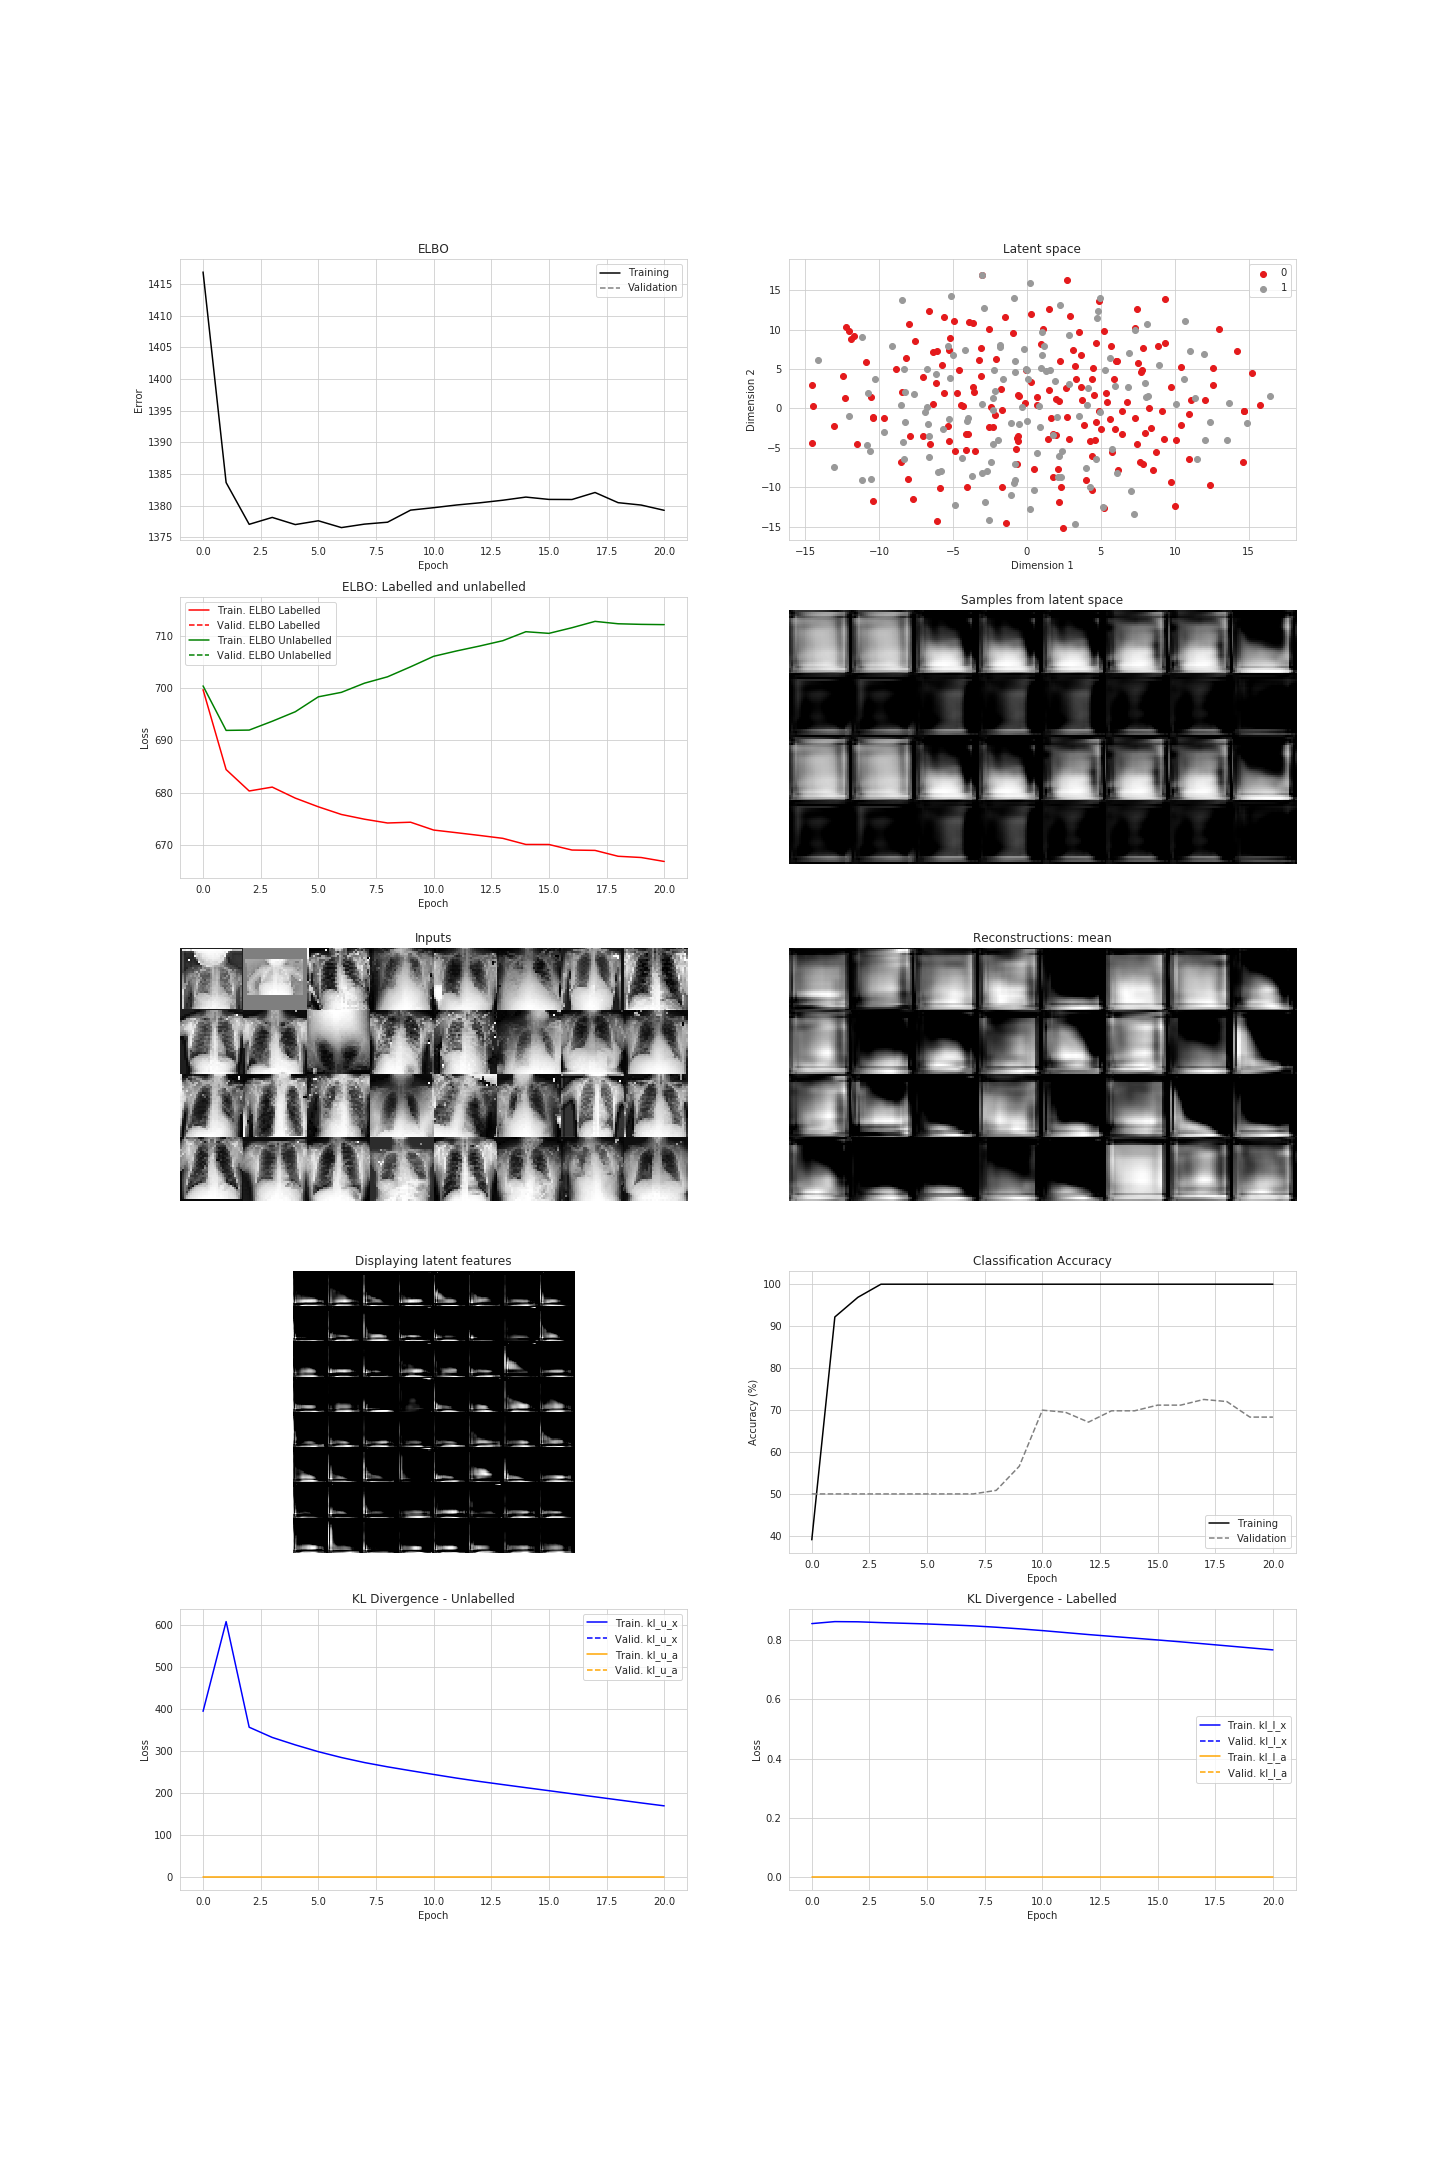

Acc:  tensor(0.6832)
TP:  tensor(150.)
FP:  tensor(60.)
TN:  tensor(75.)
FN:  tensor(35.)
P:  tensor(185.)
N:  tensor(135.)


In [10]:
## import warnings
#warnings.filterwarnings("ignore")
torch.cuda.empty_cache
# Deleting variable Image and reload package Image
%reset_selective -f "^Image$"
from IPython.display import Image
from sklearn.manifold import TSNE
import sys


import os
from sklearn.decomposition import PCA

num_epochs = 21 # No_samples_train // batch_size
batch_epo_u = No_samples_train // batch_size
batch_epo_l = No_samples_train_labelled // batch_size
batch_per_epoch = batch_epo_u if batch_epo_u>batch_epo_l else batch_epo_l


tmp_img = "tmp_vae_out.png"
show_sampling_points = False
classes = [0,1]

train_loss, valid_loss = [], []
train_kl, valid_kl = [], []
train_likelihood, valid_likelihood = [], []
train_classification, valid_classification = [], []
train_acc, valid_acc = [], []
train_L, train_H, train_kl_u_x, train_kl_u_a, train_elbo_l, train_kl_l_x, train_kl_l_a = [], [], [], [], [], [], []
valid_L, valid_H, valid_kl_u_x, valid_kl_u_a, valid_elbo_l, valid_kl_l_x, valid_kl_l_a = [], [], [], [], [], [], []
# train_latent_loss, valid_latent_loss = [], []
total_loss = []

# Classification Loss
alpha = 10 * (No_samples_train + No_samples_train_labelled) / No_samples_train_labelled   
print("Weight of classification loss (alpha): ", alpha)

# Latent Loss
beta = 0   

# Deterministic Warm-Up
deterministic_increment = 75  # The increment in the deterministic warmup. n = 10 adds 1/10 to kl_warmup for every epoch.
t_max = 1 # Maximal weight of KL divergence 

device = torch.device("cuda:0" if cuda else "cpu")
print("Using device:", device)


for epoch in range(num_epochs):
    batch_loss, batch_kl, batch_likelihood, batch_acc, batch_classification = [], [], [], [], []
    batch_L, batch_H, batch_kl_u_x, batch_kl_u_a, batch_elbo_l, batch_kl_l_x, batch_kl_l_a = [], [], [], [], [], [], []
#     batch_latent_loss = []
    net.train()
    
    # Deterministic Warmup for KL divergence
    #kl_warmup = 1
    if epoch >= deterministic_increment:
        kl_warmup = 1
    else:
        kl_warmup = epoch * 1/deterministic_increment            
    print("KL Warm-Up: ", kl_warmup)
    ###############################
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    count = 0
    total_loss_batch = 0
    for (x, y), (u, _) in zip(cycle(train_loader_labelled), train_loader):
        y_hot =  torch.zeros([batch_size,2])
        for i in range(len(y)):
            y_hot[i] = torch.tensor([0, 1]) if y[i]==1 else torch.tensor([1, 0])
            
        x, y, u, y_hot = Variable(x), Variable(y), Variable(u), Variable(y_hot)
        if cuda:
            # They need to be on the same device and be synchronized.
            x, y, y_hot = x.cuda(device=0), y.cuda(device=0), y_hot.cuda(device=0)
            u = u.cuda(device=0)

        count = count + 1
        if not count % (batch_per_epoch/4):
            print("Epoch:", epoch, "Batch:", count,"/",batch_per_epoch)

        #### Unlabelled
        outputs = net(u)
        elbo_u, elbo_H, elbo_L, kl_u, likelihood_u, kl_u_x, kl_u_a = loss_function(u, outputs, kl_warmup)
        elbo_H = elbo_H.cpu().detach().numpy()
        elbo_L = elbo_L.cpu().detach().numpy()
        kl_u_x = kl_u_x.cpu().detach().numpy()
        kl_u_a = kl_u_a.cpu().detach().numpy()
        
        #### Labelled
        outputs = net(x,y_hot)
        logits = outputs["y_hat"]
        y_hot = y_hot.unsqueeze(dim = 1).repeat(1,logits.shape[1],1)
        
        # Weight the classification loss for the two classes
        classification_loss =  alpha * balanced_binary_cross_entropy( logits, y_hot)
        acc = balanced_accuracy( logits, y_hot)
        batch_acc.append(100*acc)
        elbo_l, kl_l, likelihood_l, kl_l_x, kl_l_a = loss_function(x, outputs, kl_warmup)
        kl_l_x = kl_l_x.cpu().detach().numpy()
        kl_l_a = kl_l_a.cpu().detach().numpy()
        
        #### Latent lose
#         rho = torch.tensor(0.05)
#         act = outputs["activation"]
#         act = (act-torch.min(act)) / torch.max(act-torch.min(act))
#         # Mean over batches (training set): from [batch_size, num_samples, num_hidden_units] -> [num_samples, num_hidden_units]
#         rho_hat = torch.mean(torch.abs(act), dim = 0)
#         # Sum over num_samples and num_hidden_units
#         latent_loss = beta * torch.torch.sum(torch.abs(rho * torch.log( rho / rho_hat ) 
#                                           + (1 - rho) * torch.log( (1-rho) / (1-rho_hat)))).cuda(device=0)

        
        ### Combine losses 
        loss =  elbo_l + elbo_u + classification_loss #+ latent_loss # notice alpha has been moved to where classification loss is calculated
        total_loss_batch += loss.item()
        
        ### Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        elbo_l = elbo_l.cpu().detach().numpy()
        batch_classification.append(classification_loss.item())
        batch_loss.append(loss.item())
        batch_kl.append(kl_u.item()+kl_l.item())
        batch_likelihood.append(likelihood_u.item() + likelihood_l.item())
        batch_L.append(elbo_L) # NOT elbo_l, but L from elbo_u
        batch_H.append(elbo_H)
        batch_kl_u_x.append(kl_u_x)
        batch_kl_u_a.append(kl_u_a)
        batch_elbo_l.append(elbo_l)
        batch_kl_l_x.append(kl_l_x)
        batch_kl_l_a.append(kl_l_a)
#         latent_loss = latent_loss.cpu().detach().numpy()
#         batch_latent_loss.append(latent_loss)
    
    train_classification.append(np.mean(batch_classification))
    train_acc.append(np.mean(batch_acc))    
    train_loss.append(np.mean(batch_loss))
    train_kl.append(np.mean(batch_kl))
    train_likelihood.append(np.mean(batch_likelihood))
    total_loss.append(total_loss_batch / (batch_size*batch_per_epoch))
    train_L.append(np.mean(batch_L))
    train_H.append(np.mean(batch_H))
    train_kl_u_x.append(np.mean(batch_kl_u_x))
    train_kl_u_a.append(np.mean(batch_kl_u_a))
    train_elbo_l.append(np.mean(batch_elbo_l))
    train_kl_l_x.append(np.mean(batch_kl_l_x))
    train_kl_l_a.append(np.mean(batch_kl_l_a))
#     train_latent_loss.append(np.mean(batch_latent_loss))
    
    
    # Evaluate, do not propagate gradients
    with torch.no_grad():
        net.eval()
        
        # Just load a single batch from the test loader
        x, y = next(iter(test_loader))
        
        y_hot =  torch.zeros([batch_size,2])
        for i in range(len(y)):
            y_hot[i] = torch.tensor([0, 1]) if y[i]==1 else torch.tensor([1, 0])
        x, y, y_hot = Variable(x), Variable(y), Variable(y_hot)
        if cuda:
            # They need to be on the same device and be synchronized.
            x, y_hot = x.cuda(device=0), y_hot.cuda(device=0)
        
        #### Unlabelled
        outputs = net(u)
        elbo_u, elbo_H, elbo_L, kl_u, likelihood_u, kl_u_x, kl_u_a = loss_function(u, outputs, kl_warmup)
        elbo_H = elbo_H.cpu().detach().numpy()
        elbo_L = elbo_L.cpu().detach().numpy()
        kl_u_x = kl_u_x.cpu().detach().numpy()
        kl_u_a = kl_u_a.cpu().detach().numpy()
        
        #### Labelled
        outputs = net(x,y_hot)
        x_hat = outputs['x_hat']
        logits = outputs["y_hat"]
        z = outputs["z"]
        
        y_hot = y_hot.unsqueeze(dim = 1).repeat(1,logits.shape[1],1)
        #acc = torch.sum(y_hot.view(-1,2) * logits.view(-1,2), dim = 1).cpu().detach().numpy()
        #valid_acc.append(sum(acc > 0.5) / batch_size*num_samples)
        acc = balanced_accuracy( logits, y_hot)
        valid_acc.append(100*acc)
        
        # Weight the classification loss for the two classes
        #classWeight = torch.FloatTensor([torch.sum(y_hot[:,1,0])/torch.sum(y_hot[:,1,]), torch.sum(y_hot[:,1,1])/torch.sum(y_hot[:,1,])]).cuda(device=0)
        #classification_loss = alpha*torch.nn.functional.binary_cross_entropy(logits,y_hot, weight=classWeight)
        #classification_loss = torch.sum(torch.abs(y_hot - logits))
        #classification_loss = alpha*torch.nn.functional.binary_cross_entropy(logits,y_hot)
        classification_loss = alpha * balanced_binary_cross_entropy( logits, y_hot)
        # elbo, kl = loss_function(x_hat, x, mu, log_var)
        elbo_l, kl_l, likelihood_l, kl_l_x, kl_l_a = loss_function(x, outputs, kl_warmup)
        kl_l_x = kl_l_x.cpu().detach().numpy()
        kl_l_a = kl_l_a.cpu().detach().numpy()
        
        # We save the latent variable and reconstruction for later use
        # we will need them on the CPU to plot
        x = x.to("cpu")
        x_hat = x_hat.to("cpu")
        z = z.detach().to("cpu").numpy()
        
    
        valid_classification.append(classification_loss.item())
        valid_loss.append(elbo_l.item()+classification_loss.item()+elbo_u.item())
        valid_kl.append(kl_l.item())
        valid_likelihood.append(likelihood_l.item())
        valid_L.append(elbo_L)
        valid_H.append(elbo_H)
        valid_kl_u_x.append(kl_u_x)
        valid_kl_u_a.append(kl_u_a)
        valid_elbo_l.append(elbo_l.item())
        valid_kl_l_x.append(kl_l_x)
        valid_kl_l_a.append(kl_l_a)
        
    
    if epoch == 0:
        continue
    
    if epoch % 10:
        continue
    
    validation_from = min(20, num_epochs)
    if epoch < validation_from:
        VALIDATION = False
    else:
        VALIDATION = True
    
    # -- Plotting --
    f, axarr = plt.subplots(5, 2, figsize=(20, 30))

    # Loss
    ax = axarr[0, 0]
    ax.set_title("ELBO")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Error')

    ax.plot(np.arange(epoch+1), train_loss, color="black")
    if VALIDATION:
        ax.plot(np.arange(epoch+1)[validation_from:len(valid_loss)], valid_loss[validation_from:len(valid_loss)], color="gray", linestyle="--")
        ax.legend(['Training', 'Validation'])
    else:
        ax.legend(['Training'])
        
        
    # Latent space
    ax = axarr[0, 1]
    ax.set_title('Latent space')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    
    if batch_size > 4:
        rows = 4
        columns = batch_size // rows if batch_size // rows < 8 else 8            
    else:
        rows = 2
        columns = 2
    
    span = np.linspace(-4, 4, rows)
    grid = np.dstack(np.meshgrid(span, span)).reshape(-1, 2)
    
    # If you want to use a dimensionality reduction method you can use
    # for example PCA by projecting on two principal dimensions

    """ PCA """
    #z = PCA(n_components=2).fit_transform(z.reshape(-1,latent_features))
    #z = z.reshape(batch_size,num_samples,2)
    
    """ TSNE """
    z = TSNE(n_components=2).fit_transform(z.reshape(-1,latent_features))
    z = z.reshape(batch_size,num_samples,2)
    #z = z[:,1,] # We do only want to plot one z instead of |num_samples|
    
    colors = iter(plt.get_cmap('Set1')(np.linspace(0, 1.0, len(classes))))
    for c in classes:
        ax.scatter(*z[c == y.numpy()].reshape(-1, 2).T, c=next(colors), marker='o', label=c)
        
    if show_sampling_points:
        ax.scatter(*grid.T, color="k", marker="x", alpha=0.5, label="Sampling points")

    ax.legend()
    
    # KL / reconstruction
    ax = axarr[1, 0]
    
    ax.set_title("Losses")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')

    ax.set_title("ELBO: Labelled and unlabelled")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')        
    if VALIDATION:
        ax.plot(np.arange(epoch+1), train_elbo_l, color="red")
        ax.plot(np.arange(epoch+1)[validation_from:len(valid_loss)], valid_elbo_l[validation_from:len(valid_loss)], color="red", linestyle="--")
        ax.plot(np.arange(epoch+1), train_L, color="green")  
        ax.plot(np.arange(epoch+1)[validation_from:len(valid_loss)], valid_L[validation_from:len(valid_loss)], color="green", linestyle="--") 
        ax.legend(['Train. ELBO Labelled',  'Valid. ELBO Labelled', 'Train. ELBO Unlabelled', 'Valid. ELBO Unlabelled'])
    else:
        ax.plot(np.arange(epoch+1), train_elbo_l, color="red")
        ax.plot(np.arange(epoch+1), train_L, color="green")    # Typically L >>> H, therefore not L+H   
        ax.legend(['Train. ELBO Labelled', 'Train. ELBO Unlabelled'])
    
    # Latent space samples
    ax = axarr[1, 1]
    ax.set_title('Samples from latent space')
    ax.axis('off')

    with torch.no_grad():
        epsilon = torch.randn(batch_size, latent_features).to(device)
        samples = torch.sigmoid(net.sample_from_latent(epsilon)).cpu().detach().numpy()

    canvas = np.zeros((IMG_SIZE*rows, columns*IMG_SIZE))
    for i in range(rows):
        for j in range(columns):
            idx = i % columns + rows * j
            #temp_img = samples[idx].reshape((224, 224))
            #canvas[i*28:(i+1)*28, j*28:(j+1)*28] = resize(temp_img, output_shape=[28,28], mode='reflect', anti_aliasing=True)
            canvas[i*IMG_SIZE:(i+1)*IMG_SIZE, j*IMG_SIZE:(j+1)*IMG_SIZE] = samples[idx,0:IMG_SIZE**2].reshape((IMG_SIZE, IMG_SIZE))
    ax.imshow(canvas, cmap='gray')

    # Inputs
    ax = axarr[2, 0]
    ax.set_title('Inputs')
    ax.axis('off')

    canvas = np.zeros((IMG_SIZE*rows, columns*IMG_SIZE))
    for i in range(rows):
        for j in range(columns):
            idx = i % columns + rows * j
            #temp_img = x[idx].reshape((224, 224))
            #canvas[i*28:(i+1)*28, j*28:(j+1)*28] = resize(temp_img, output_shape=[28,28], mode='reflect', anti_aliasing=True)
            canvas[i*IMG_SIZE:(i+1)*IMG_SIZE, j*IMG_SIZE:(j+1)*IMG_SIZE] = x[idx,0:IMG_SIZE**2].reshape((IMG_SIZE, IMG_SIZE))
    ax.imshow(canvas, cmap='gray')

    # Reconstructions
    ax = axarr[2, 1]
    ax.set_title('Reconstructions: mean')
    ax.axis('off')

    canvas = np.zeros((IMG_SIZE*rows, columns*IMG_SIZE))
    for i in range(rows):
        for j in range(columns):
            idx = i % columns + rows * j
            #temp_img = x_hat[idx].reshape((224, 224))
            #canvas[i*28:(i+1)*28, j*28:(j+1)*28] = resize(temp_img, output_shape=[28,28], mode='reflect', anti_aliasing=True)
            canvas[i*IMG_SIZE:(i+1)*IMG_SIZE, j*IMG_SIZE:(j+1)*IMG_SIZE] = normalize_2(x_hat[idx,0:IMG_SIZE**2].reshape((IMG_SIZE, IMG_SIZE)))
    ax.imshow(canvas, cmap='gray')

    # Reconstructions
    ax = axarr[3, 0]
    ax.axis('off')
    #ax.set_title('Reconstructions: sigma')
    #sigma = (torch.exp(outputs["x_log_var"]/2)).detach().to("cpu").numpy()
    #canvas = np.zeros((IMG_SIZE*rows, columns*IMG_SIZE))
    #for i in range(rows):
    #    for j in range(columns):
    #        idx = i % columns + rows * j
    #        #temp_img = x_hat[idx].reshape((224, 224))
    #        #canvas[i*28:(i+1)*28, j*28:(j+1)*28] = resize(temp_img, output_shape=[28,28], mode='reflect', anti_aliasing=True)
    #        canvas[i*IMG_SIZE:(i+1)*IMG_SIZE, j*IMG_SIZE:(j+1)*IMG_SIZE] = sigma[idx,0:IMG_SIZE**2].reshape((IMG_SIZE, IMG_SIZE))
    #ax.imshow(canvas, cmap='gray')
    ax.set_title('Displaying latent features')
    with torch.no_grad():
        latent_feature = torch.zeros(batch_size,latent_features).to(device)
        for i in range(0,latent_features if latent_features<= batch_size else batch_size):
            latent_feature[i,i] = 100
        displaying_latent_features = (net.sample_from_latent(latent_feature)).cpu().detach() #no sigmoid, instead normalize later
        
    if displaying_latent_features.shape[0] == 64: 
        rows_2 = 8
        columns_2 = 8
    elif displaying_latent_features.shape[0] == 128: 
        rows_2 = 8
        columns_2 = 16
    else:
        rows_2 = rows
        columns_2 = columns   
    canvas = np.zeros((IMG_SIZE*rows_2, columns_2*IMG_SIZE))  
    for i in range(rows_2):
        for j in range(columns_2):
            idx = i % columns_2 + rows_2 * j
            canvas[i*IMG_SIZE:(i+1)*IMG_SIZE, j*IMG_SIZE:(j+1)*IMG_SIZE] = normalize_2(displaying_latent_features[idx,0:IMG_SIZE**2].reshape((IMG_SIZE, IMG_SIZE)))
    ax.imshow(canvas, cmap='gray')
    
                
    # Classification Loss
    ax = axarr[3, 1]
    ax.set_title("Classification Accuracy")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (%)')
    
    ax.plot(np.arange(epoch+1), train_acc, color="black")
    ax.plot(np.arange(epoch+1), valid_acc, color="gray", linestyle="--")
    ax.legend(['Training', 'Validation'])
    
    # KL Divergence - Unlabelled
    ax = axarr[4,0]
    ax.set_title("KL Divergence - Unlabelled")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    if VALIDATION:
        ax.plot(np.arange(epoch+1), train_kl_u_x, color="blue")
        ax.plot(np.arange(epoch+1)[validation_from:len(valid_loss)], valid_kl_u_x[validation_from:len(valid_loss)], color="blue", linestyle="--")
        ax.plot(np.arange(epoch+1), train_kl_u_a, color="orange")
        ax.plot(np.arange(epoch+1)[validation_from:len(valid_loss)], valid_kl_u_a[validation_from:len(valid_loss)], color="orange", linestyle="--")
        ax.legend(['Train. kl_u_x',  'Valid. kl_u_x', 'Train. kl_u_a', 'Valid. kl_u_a'])
    else:
        ax.plot(np.arange(epoch+1), train_kl_u_x, color="blue")
        ax.plot(np.arange(epoch+1), train_kl_u_a, color="orange")
        ax.legend(['Train. kl_u_x',  'Train. kl_u_a'])

    # KL Divergence - Labelled
    ax = axarr[4,1]
    ax.set_title("KL Divergence - Labelled")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    if VALIDATION:
        ax.plot(np.arange(epoch+1), train_kl_l_x, color="blue")
        ax.plot(np.arange(epoch+1)[validation_from:len(valid_loss)], valid_kl_l_x[validation_from:len(valid_loss)], color="blue", linestyle="--")
        ax.plot(np.arange(epoch+1), train_kl_l_a, color="orange")
        ax.plot(np.arange(epoch+1)[validation_from:len(valid_loss)], valid_kl_l_a[validation_from:len(valid_loss)], color="orange", linestyle="--")
        #ax.plot(np.arange(epoch+1), train_latent_loss, color="green")
        ax.legend(['Train. kl_l_x',   'Valid. kl_l_x', 'Train. kl_l_a', 'Valid. kl_l_a'])
        #ax.legend(['Train. kl_l_x',   'Valid. kl_l_x', 'Train. kl_l_a', 'Valid. kl_l_a', 'Latent_loss'])
    else:
        ax.plot(np.arange(epoch+1), train_kl_l_x, color="blue")
        ax.plot(np.arange(epoch+1), train_kl_l_a, color="orange")
        #ax.plot(np.arange(epoch+1), train_latent_loss, color="green")
        ax.legend(['Train. kl_l_x',  'Train. kl_l_a'])
        #ax.legend(['Train. kl_l_x',  'Train. kl_l_a',  'Latent_loss'])
    
    clear_output(wait=True)
    plt.savefig(tmp_img)
    plt.close(f)
    display(Image(filename=tmp_img))

    os.remove(tmp_img)
    
    if epoch % 20:
        continue
    
    # Run trough full test data set
    TP, FP, FN, TN, P, N = 0, 0, 0, 0, 0, 0
    for (x, y) in test_loader:
        y_hot =  torch.zeros([batch_size,2])

        for i in range(len(y)):
            y_hot[i] = torch.tensor([0, 1]) if y[i]==1 else torch.tensor([1, 0])
        x, y, y_hot = Variable(x), Variable(y), Variable(y_hot)
        if cuda:
            # Must be synchronized on the same device
            x, y_hot = x.cuda(device=0), y_hot.cuda(device=0)

        #### Labelled
        outputs = net(x,y_hot)
        logits = outputs["y_hat"]
        y_hot = y_hot.unsqueeze(dim = 1).repeat(1,logits.shape[1],1)
        acc_1, TP_1, FP_1, FN_1, TN_1, P_1, N_1 = balanced_accuracy_test(logits, y_hot)
        TP += TP_1
        FP += FP_1
        FN += FN_1
        TN += TN_1
        P  += P_1
        N  += N_1

    acc =  torch.sum(TP/P + TN/N)/2  
    print("Acc: ",acc)    
    print("TP: ",TP)
    print("FP: ",FP)
    print("TN: ",TN)
    print("FN: ",FN)
    print("P: ",P)
    print("N: ",N)

In [11]:
# Run trough full test data set
TP, FP, FN, TN, P, N = 0, 0, 0, 0, 0, 0
for (x, y) in test_loader:
    y_hot =  torch.zeros([batch_size,2])
    
    for i in range(len(y)):
        y_hot[i] = torch.tensor([0, 1]) if y[i]==1 else torch.tensor([1, 0])
    x, y, y_hot = Variable(x), Variable(y), Variable(y_hot)
    if cuda:
        # Must be synchronized on the same device
        x, y_hot = x.cuda(device=0), y_hot.cuda(device=0)

    #### Labelled
    outputs = net(x,y_hot)
    logits = outputs["y_hat"]
    y_hot = y_hot.unsqueeze(dim = 1).repeat(1,logits.shape[1],1)
    acc_1, TP_1, FP_1, FN_1, TN_1, P_1, N_1 = balanced_accuracy_test(logits, y_hot)
    TP += TP_1
    FP += FP_1
    FN += FN_1
    TN += TN_1
    P  += P_1
    N  += N_1

acc =  torch.sum(TP/P + TN/N)/2  
print("Acc: ",acc)    
print("TP: ",TP)
print("FP: ",FP)
print("TN: ",TN)
print("FN: ",FN)
print("P: ",P)
print("N: ",N)

Acc:  tensor(0.6832)
TP:  tensor(150.)
FP:  tensor(60.)
TN:  tensor(75.)
FN:  tensor(35.)
P:  tensor(185.)
N:  tensor(135.)
